# Diversity Evolutionary Algorithm

In [1]:
from functools import partial

import numpy as np

from ariel.body_phenotypes.robogen_lite.decoders.hi_prob_decoding import (
    HighProbabilityDecoder,
)
from ariel.ec.a004 import (
    EA,
    EASettings,
    EAStep,
    Individual,
    Population,
    parent_selection,
)
from ariel.ec.genotypes.nde.nde import NeuralDevelopmentalEncoding
from ariel_experiments.characterize.canonical.core.toolkit import (
    CanonicalToolKit as ctk,
)
from ariel_experiments.characterize.individual import analyze_neighbourhood
from ariel_experiments.characterize.population import (
    get_full_analyzed_population,
    matrix_derive_neighbourhood,
)

#from examples.z_ec_course.A3_template import NUM_OF_MODULES

import networkx as nx
from ariel_experiments.gui_vis.view_mujoco import view
import matplotlib.pyplot as plt

NUM_OF_MODULES = 20
SEED = 42
RNG = np.random.default_rng(SEED)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Settings

In [2]:
# Global var
global_fitness_history = []
global_novelty_history = []
old_pop = []
# EA settings
config = EASettings()
config.is_maximisation = False
config.num_of_generations = 30
config.target_population_size = 1000 # this is the starting population

# evaluation settings
similarity_config = ctk.create_similarity_config(
    radius_strategy=ctk.RadiusStrategy.TREE_GLOBAL,
    weighting_mode=ctk.WeightingMode.LINEAR,
    max_tree_radius=3,
    missing_data_mode=ctk.MissingDataMode.TREAT_AS_ZERO,
    softmax_beta=1,
)

In [3]:
def float_creep(
    individual: list[list[float]] | list[list[list[float]]],
    mutation_probability: float,
) -> list[list[float]]:
    # Prep
    ind_arr = np.array(individual)
    shape = ind_arr.shape

    # Generate mutation values
    mutator = RNG.uniform(
        size=shape,
    )

    # Include negative mutations
    sub_mask = RNG.choice(
        [-1, 1],
        size=shape,
    )

    # Determine which positions to mutate
    do_mask = RNG.choice(
        [1, 0],
        size=shape,
        p=[mutation_probability, 1 - mutation_probability],
    )
    mutation_mask = mutator * sub_mask * do_mask
    new_genotype = ind_arr + mutation_mask
    return new_genotype.tolist()

In [4]:
from ariel_experiments.characterize.population import matrix_derive_neighbourhood_cross_pop


def novelty(current_population: Population, old_population: Population) -> float:
    """
    returns the diversity between the last two populations
    """
    score = 0

    analyzed_population_1 = get_full_analyzed_population(
        current_population,
        analyzers=[partial(analyze_neighbourhood, config=similarity_config)],
        derivers=[],
        n_jobs=-1,
        hide_tracker=True,
    )
    analyzed_population_2 = get_full_analyzed_population(
        old_population,
        analyzers=[partial(analyze_neighbourhood, config=similarity_config)],
        derivers=[],
        n_jobs=-1,
        hide_tracker=True,
    )
   
    matrix_result = matrix_derive_neighbourhood_cross_pop(
        (analyzed_population_1.raw,analyzed_population_2.raw),
        config=similarity_config,
        n_jobs=-1,
        hide_tracker=True,
    )
    matrix = matrix_result["similarity_matrix"]["full"]

    for index in range(len(current_population)):

        score += np.sum(matrix[index])
            
    return (score/(len(current_population)*len(old_population)))

In [5]:
##################################
def record_mean_fitness(population: Population) -> Population:
    new_pop = [ctk.to_graph(ctk.from_string(ind.tags["graph"])) for ind in population if ind.alive == True]
    global old_pop

    mean_fitness = np.mean([ind.fitness for ind in population if hasattr(ind, 'fitness')])

    global_fitness_history.append(mean_fitness)
    novelty_score = novelty(new_pop, old_pop)
    global_novelty_history.append(novelty_score)

#     print(f"Generation {len(global_fitness_history)} - Mean fitness: {mean_fitness:.4f}", 
#           f"Novelty: {novelty_score}")
    old_pop = new_pop
    return population

# EA functions

In [6]:
def make_random_robot(genotype_size: int = 64) -> Individual:
    """
    Produces an robot with only its genotype.

    genotype_size is standard 64
    """
    ind = Individual()
    ind.genotype = [
        RNG.random(genotype_size).tolist(),
        RNG.random(genotype_size).tolist(),
        RNG.random(genotype_size).tolist(),
    ]
    nde = NeuralDevelopmentalEncoding(number_of_modules=NUM_OF_MODULES)
    hpd = HighProbabilityDecoder(num_modules=NUM_OF_MODULES)

    matrixes = nde.forward(np.array(ind.genotype))
    ind.tags["graph"] = ctk.to_string(ctk.from_graph(hpd.probability_matrices_to_graph(
        matrixes[0], matrixes[1], matrixes[2]
    )))
    return evaluation_diversity([ind])[0]


def crossover(population: Population) -> Population:
    """Does uniform crossover."""
    mask = RNG.random(size=np.array(population[0].genotype).shape) < 0.5
    children = []
    for parent in population:
        child = Individual()
        parent2 = RNG.choice(population)
        child.genotype = np.where(
            mask, np.array(parent.genotype), np.array(parent2.genotype)
        ).tolist()
        children.append(child)
    population.extend(children)
    return population


def mutation(population: Population) -> Population:
    """Randomly changes genotype values by a random amount."""
    mutation_rate = 0.01  # mutation rate to be changed
    for ind in population:
        if ind.tags.get("mut", False):
            genes = ind.genotype
            mutated = [
                float_creep(
                    individual=genes[0],
                    mutation_probability=mutation_rate,
                ),
                float_creep(
                    individual=genes[1],
                    mutation_probability=mutation_rate,
                ),
                float_creep(
                    individual=genes[2],
                    mutation_probability=mutation_rate,
                ),
            ]
            ind.genotype = mutated
            ind.requires_eval = True
    return population


def evaluation_diversity(population: Population) -> Population:
    """Produces an individual that is evaluated."""
    graph_population = [None] * len(population)

    # for initial population creation
    if len(population) <= 1:
        population[0].fitness = 0.0
        population[0].requires_eval = True
        return population

    for idx, ind in enumerate(population):
        if "graph" in ind.tags:
            graph_population[idx] = ctk.to_graph(ctk.from_string(ind.tags["graph"]))
        else:
            nde = NeuralDevelopmentalEncoding(number_of_modules=NUM_OF_MODULES)
            hpd = HighProbabilityDecoder(num_modules=NUM_OF_MODULES)

            matrixes = nde.forward(np.array(ind.genotype))
            ind_graph = hpd.probability_matrices_to_graph(
                matrixes[0], matrixes[1], matrixes[2]
            )
            ind.tags["graph"] = ctk.to_string(ctk.from_graph(ind_graph))
            graph_population[idx] = ind_graph

    analyzed_population = get_full_analyzed_population(
        graph_population,
        analyzers=[partial(analyze_neighbourhood, config=similarity_config)],
        derivers=[],
        n_jobs=-1,
        hide_tracker=True,
    )
    matrix_result = matrix_derive_neighbourhood(
        analyzed_population.raw,
        config=similarity_config,
        symmetric=True,
        n_jobs=-1,
        hide_tracker=True,
    )
    matrix = matrix_result["similarity_matrix"]["full"]

    for index, ind in enumerate(population):
        if ind.requires_eval:
            ind.requires_eval = False  # diversity gets evaluated each time

            fitness = np.sum(matrix[index])
            population[index].fitness = (float(fitness) - 1) / len(population)

    return population


def survivor_selection(population: Population) -> Population:
    
    RNG.shuffle(population)
    current_pop_size = len(population)

    for idx in range(0, len(population) - 1, 2):
        ind_i = population[idx]
        ind_j = population[idx + 1]

        if config.is_maximisation:
            if ind_i.fitness < ind_j.fitness:
                ind_i.alive = False
            else:
                ind_j.alive = False
        else:
            if ind_i.fitness > ind_j.fitness:
                ind_i.alive = False
            else:
                ind_j.alive = False
        current_pop_size -= 1
        if current_pop_size <= config.target_population_size:
            break

    return population


# run


In [7]:
all_generations_graphs = []

def record_graphs(population: Population) -> Population:
    global all_generations_graphs
    gen_graphs = [
        ctk.to_graph(ctk.from_string(ind.tags["graph"]))
        for ind in population
        if ind.alive
    ]
    all_generations_graphs.append(gen_graphs)
    return population

In [8]:
ops = [
    EAStep("parent_selection", parent_selection),
    EAStep("crossover", crossover),
    EAStep("mutation", mutation),
    EAStep("evaluation", evaluation_diversity),
    EAStep("survivor_selection", survivor_selection),
    EAStep("record_graphs", record_graphs),
    EAStep("record_fitness", record_mean_fitness),
]

# population = [ make_random_robot(genotype_size) for _ in range(10)] # generating genotypes
# robot = nde.forward(np.array(population[0].genotype))
# evaluation_diversity(population=population)

In [9]:
# hyperparameters
population_size = 10
num_of_generations = 5
genotype_size = 64  # 64 is standard in the NDE


# population
population_list = [
    make_random_robot(genotype_size) for _ in range(config.target_population_size)
]  # generating genotypes
old_pop = [ctk.to_graph(ctk.from_string(ind.tags["graph"])) for ind in population_list]

In [10]:
# I USED THIS TO VISUALIZE

# # place in cell above:
# # tracker = 0


# # place in cell below
# nde = NeuralDevelopmentalEncoding(number_of_modules=NUM_OF_MODULES)
# hpd = HighProbabilityDecoder(num_modules=NUM_OF_MODULES)
# matrixes = nde.forward(np.array(population_list[tracker].genotype))
# ind_graph = hpd.probability_matrices_to_graph(
#     matrixes[0], matrixes[1], matrixes[2]
# )

# view(ind_graph)
# tracker + (tracker + 1) % len(population_list)

In [11]:
def most_similar_pair(graphs):
    analyzed_population = get_full_analyzed_population(
        graphs,
        analyzers=[partial(analyze_neighbourhood, config=similarity_config)],
        derivers=[],
        n_jobs=-1,
        hide_tracker=True,
    )

    matrix_result = matrix_derive_neighbourhood(
        analyzed_population.raw,
        config=similarity_config,
        symmetric=True,
        n_jobs=-1,
        hide_tracker=True,
    )

    sim_matrix = matrix_result["similarity_matrix"]["full"]

    n = len(graphs)
    best = None
    best_pair = (None, None)

    for i in range(n):
        for j in range(i + 1, n):
            if best is None or sim_matrix[i][j] > best:
                best = sim_matrix[i][j]
                best_pair = (i, j)

    return best_pair[0], best_pair[1], best, sim_matrix

def plot_two_mujocos(
    graph1: nx.DiGraph, graph2: nx.DiGraph, name_list: list[str] | None = None
):
    img1 = view(graph1, return_img=True)
    img2 = view(graph2, return_img=True)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

    ax1.imshow(img1)
    if name_list:
        ax1.set_title(name_list[0])
    ax1.axis("off")

    ax2.imshow(img2)
    if name_list:
        ax2.set_title(name_list[1])
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

def show_most_similar_for_generations(generations=[0, 9, 19, 29]):
    for gen in generations:
        print(f"\n *GENERATION {gen}*")

        graphs = all_generations_graphs[gen]

        i, j, sim_val, sim_matrix = most_similar_pair(graphs)

        print(f"Most similar robots: {i} and {j}")
        print(f"Similarity score = {sim_val:.4f}")

        g1 = graphs[i]
        g2 = graphs[j]

        node1 = ctk.from_graph(g1).canonicalize()
        node2 = ctk.from_graph(g2).canonicalize()

        plot_two_mujocos(
            node1.to_graph(),
            node2.to_graph(),
            [
                f"Gen {gen} - robot {i} (sim={sim_val:.3f})",
                f"Gen {gen} - robot {j} (sim={sim_val:.3f})",
            ],
        )

# In case we want to see more details about similarity
#        results = ctk.calculate_similarity(
#            node1, node2, config=similarity_config, return_all=True
#        )


In [12]:
ea = EA(
    population_list,
    operations=ops,
    num_of_generations=config.num_of_generations
)

ea.run()

[01:15:55] Database file exists at                                                                       ]8;id=102944;file://C:\Users\saram\OneDrive\Desktop\ariel-zoo-main\src\ariel\ec\a004.py\a004.py]8;;\:]8;id=817902;file://C:\Users\saram\OneDrive\Desktop\ariel-zoo-main\src\ariel\ec\a004.py#98\98]8;;\
           c:\Users\saram\OneDrive\Desktop\ariel-zoo-main\zoo\__data__\database.db!                                
           Behaviour is set to: 'delete' --> ⚠️  Deleting file!                                                     

───────────────────────────────────────────────── EA Initialised ──────────────────────────────────────────────────

Output()

─────────────────────────────────────────────── EA Finished Running ───────────────────────────────────────────────

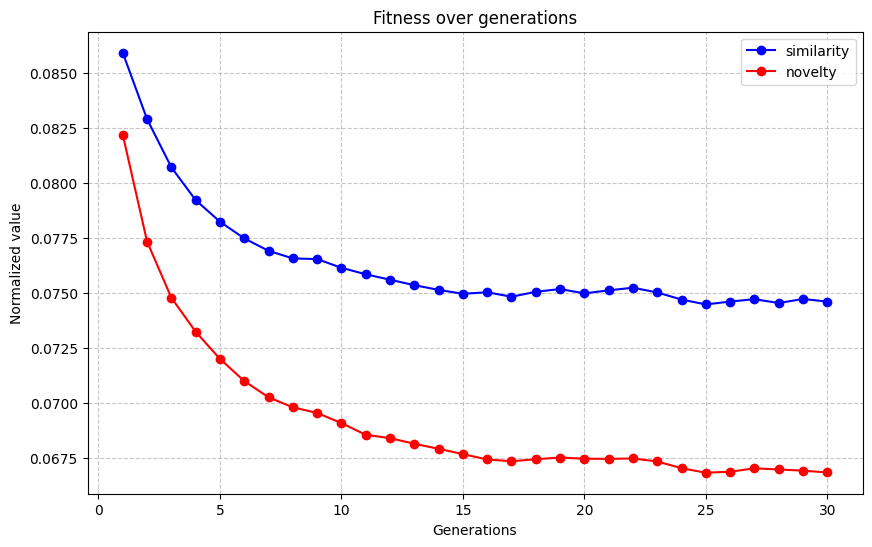

In [13]:
def plot_fitness_history():
    if not global_fitness_history:
        print("No fitness recorded for plotting")
        return

    generations = range(1, len(global_fitness_history) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(
        generations, 
        global_fitness_history, 
        marker='o', 
        linestyle='-', 
        color='blue',
        label="similarity"
    )
    plt.plot(
        generations, 
        global_novelty_history, 
        marker='o', 
        linestyle='-', 
        color='red',
        label="novelty"
    )
    plt.legend(loc="upper right")
    plt.title('Fitness over generations')
    plt.xlabel('Generations')
    plt.ylabel('Normalized value') 
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

plot_fitness_history()


 *GENERATION 0*
Most similar robots: 197 and 864
Similarity score = 0.3450


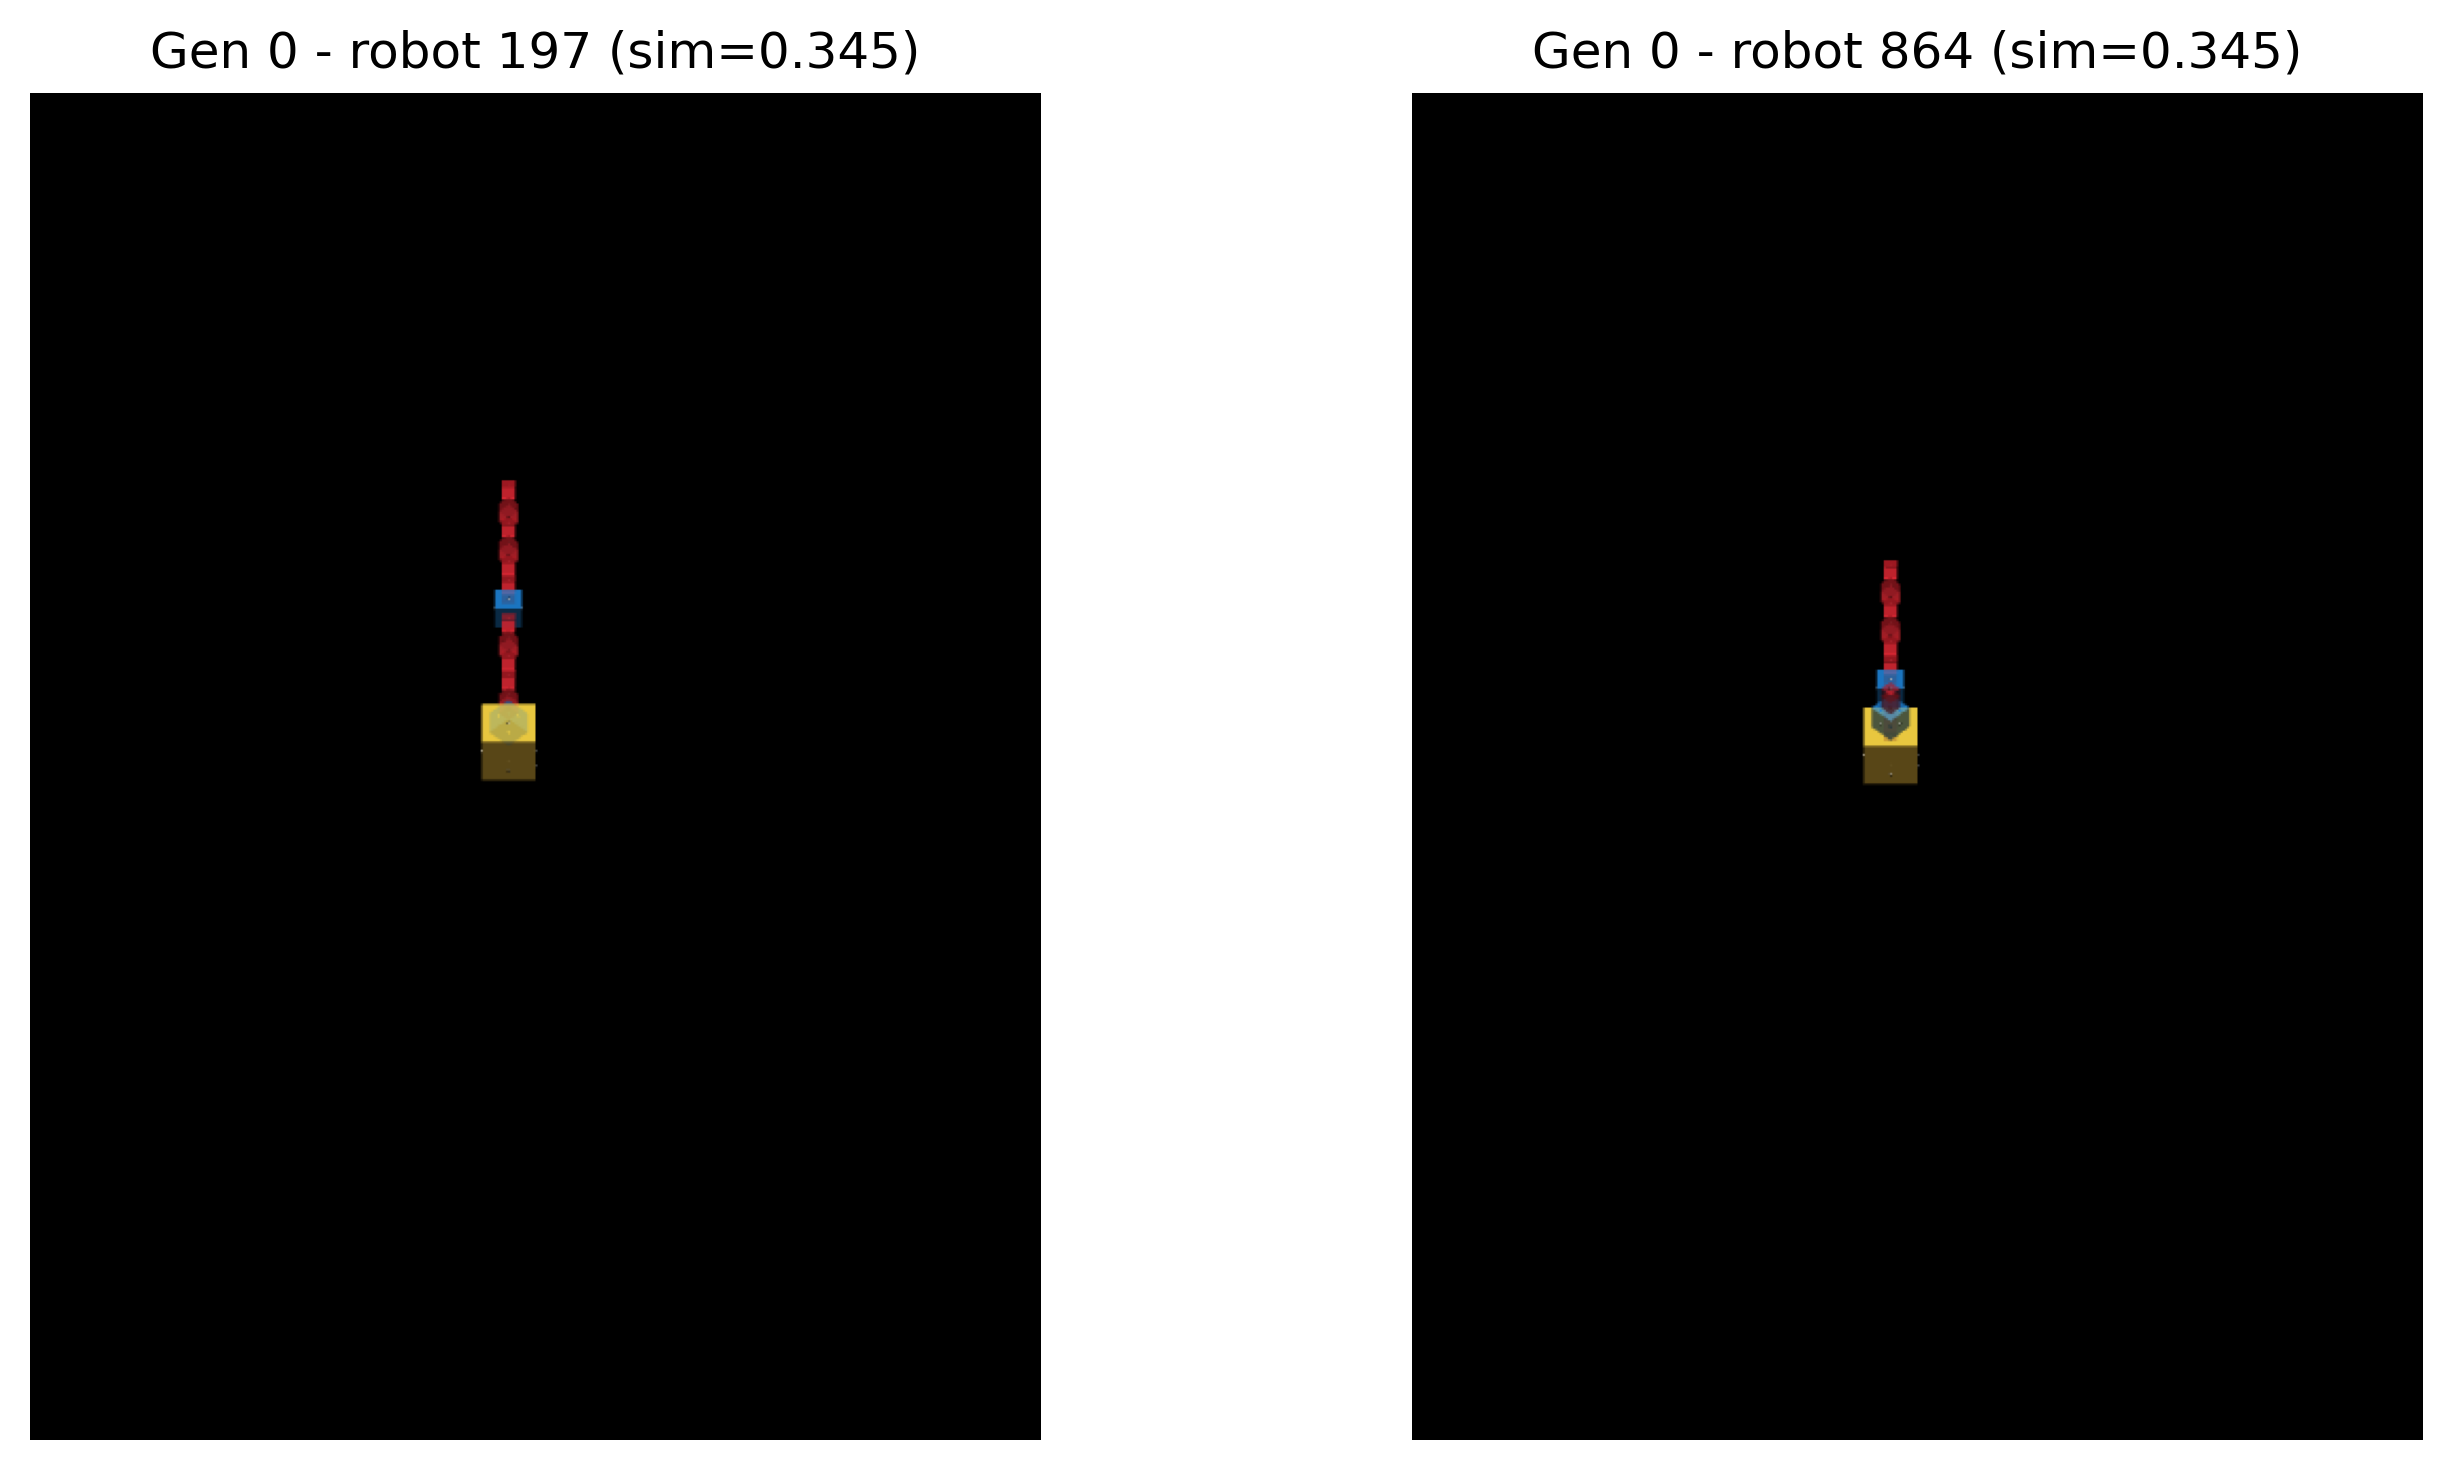


 *GENERATION 9*
Most similar robots: 374 and 475
Similarity score = 0.3450


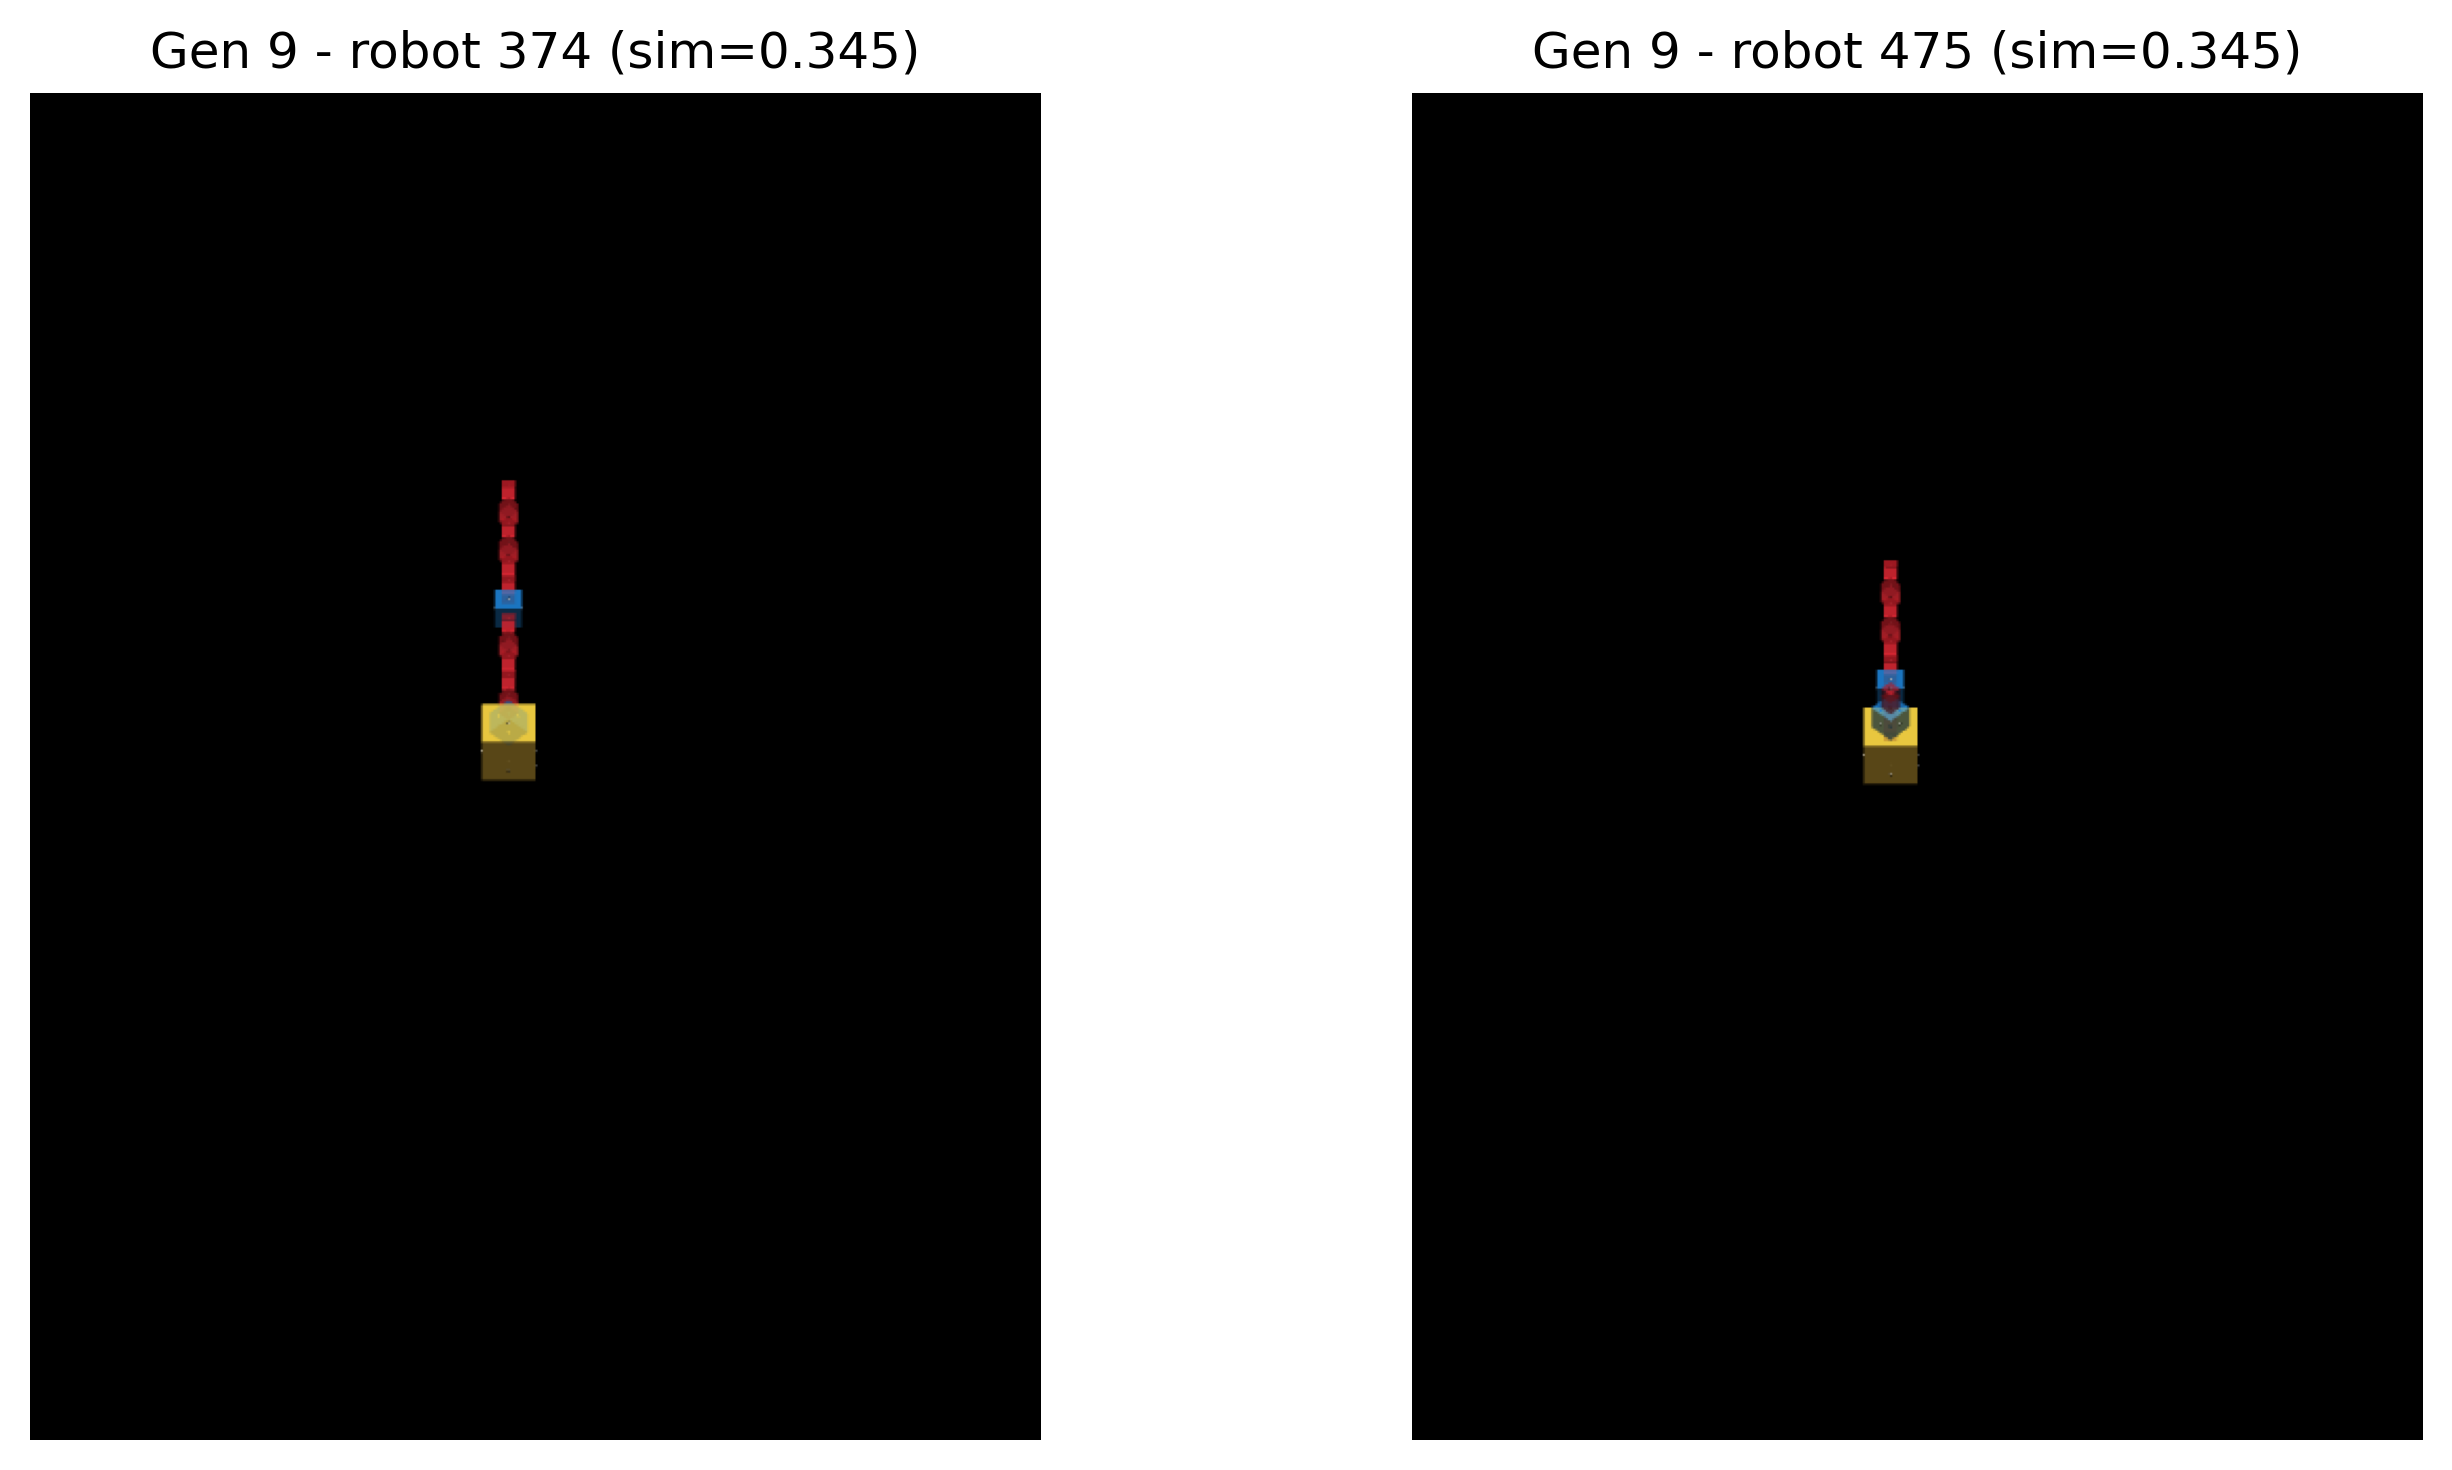


 *GENERATION 19*
Most similar robots: 296 and 324
Similarity score = 0.3450


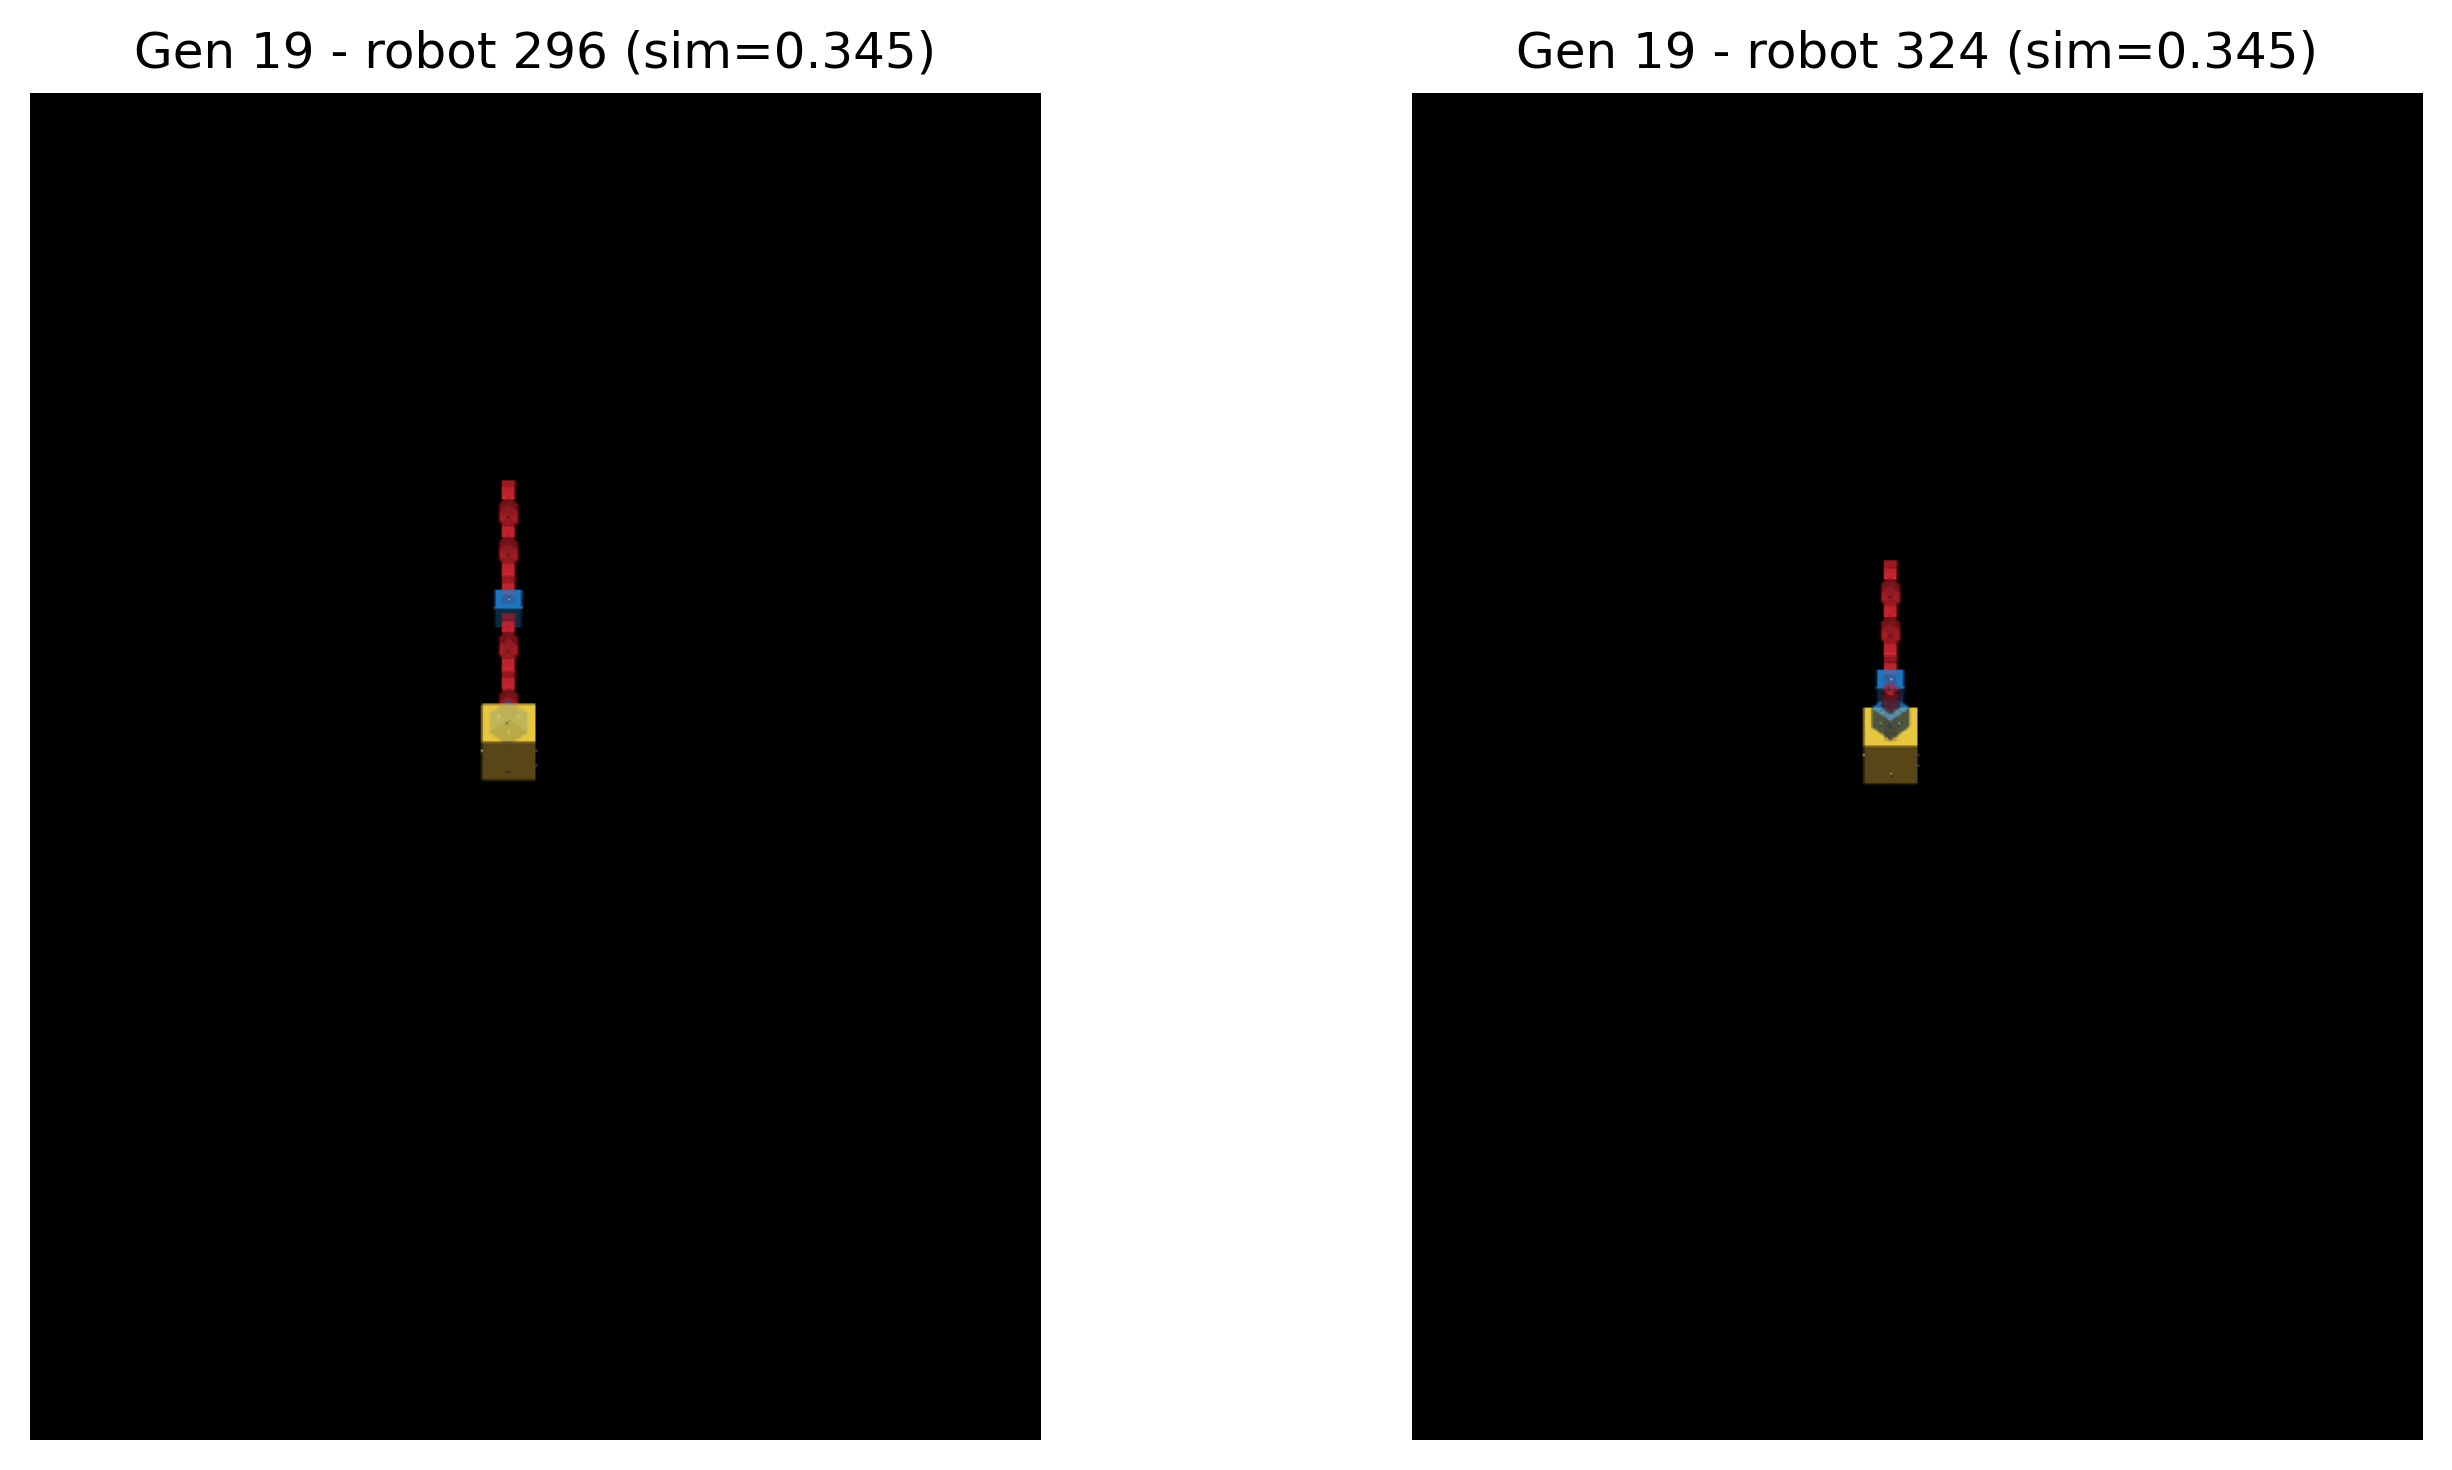


 *GENERATION 29*
Most similar robots: 397 and 610
Similarity score = 0.4700


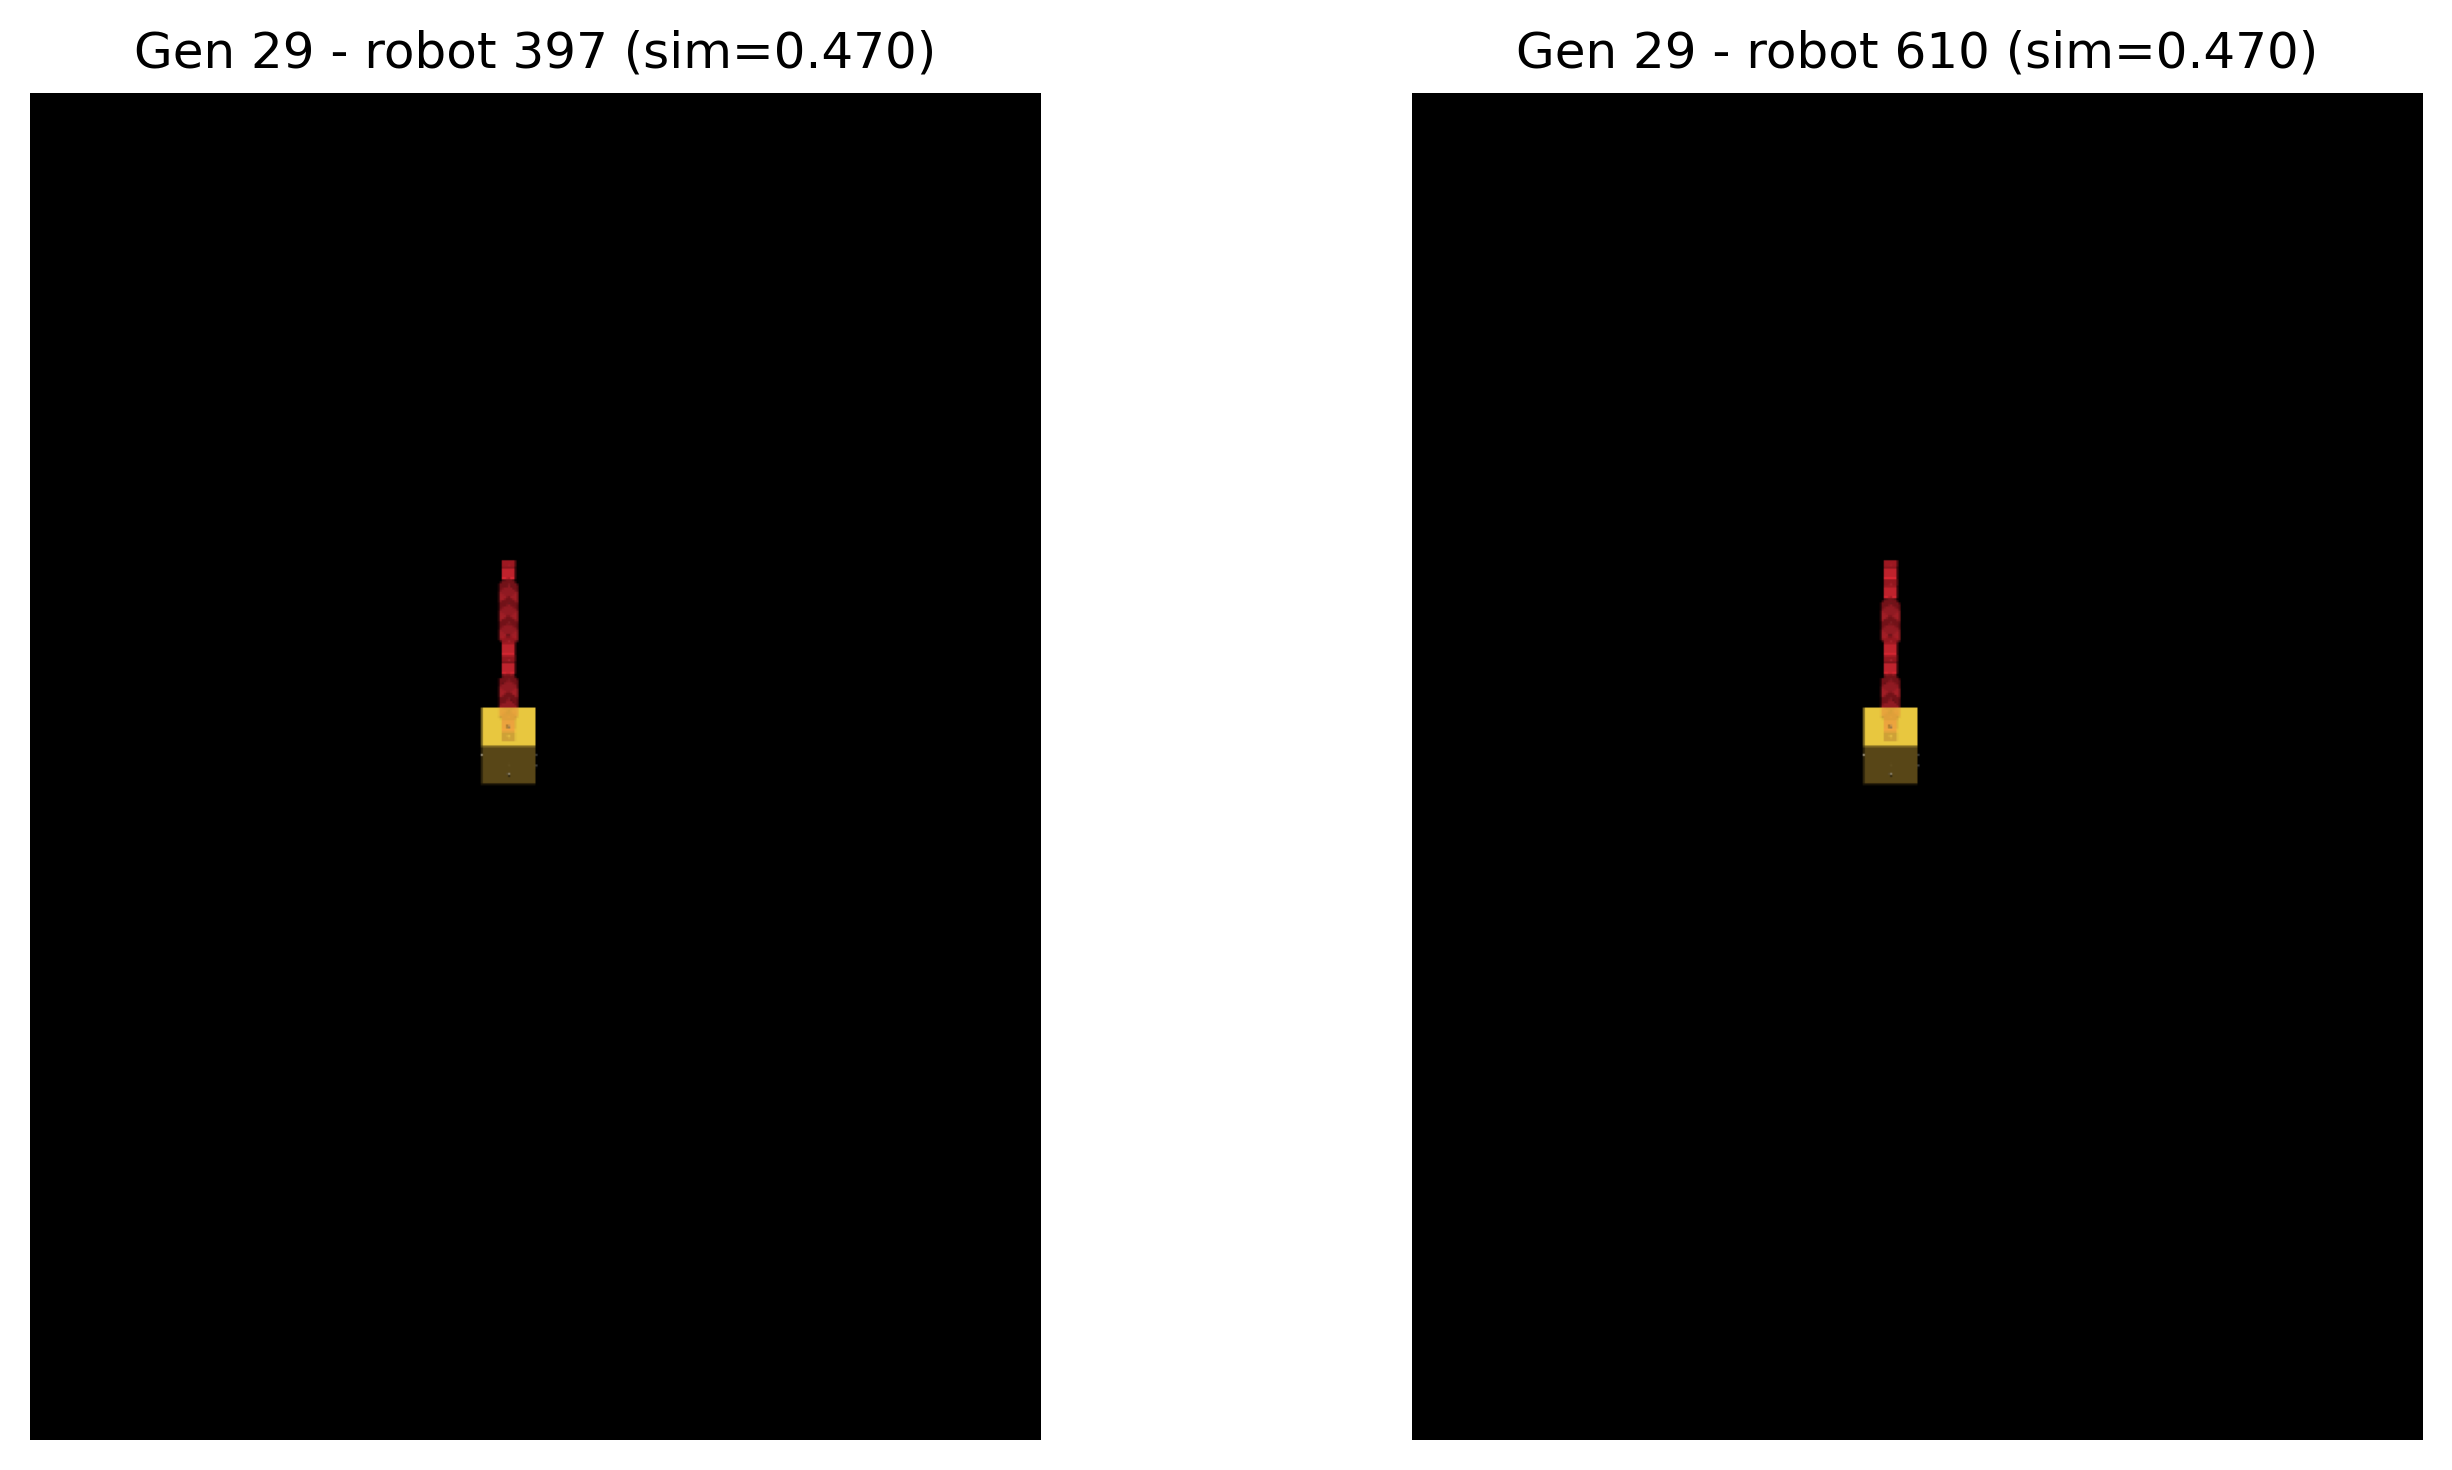

In [15]:
show_most_similar_for_generations([0, 9, 19, 29])